<a href="https://colab.research.google.com/github/youngbin0417/ML-exercises/blob/main/fine_tuning_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install imgaug

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from collections import defaultdict, Counter
from torchsummary import summary

import os
import copy
import time
import numpy as np
import matplotlib.pyplot as plt

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.6.0+cu124
Torchvision Version:  0.21.0+cu124


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/challenge
!pwd


/content/drive/My Drive/challenge
/content/drive/My Drive/challenge


## Prepair Dataset

In [ ]:
from PIL import Image
import torchvision.transforms.functional as F

data_dir = './images_preprocessed'
input_size = 224
batch_size = 32

# class 이름 매핑
class_names = ['Bicycle', 'Bridge', 'Bus', 'Car',
               'Chimney', 'Crosswalk', 'Hydrant',
               'Motorcycle', 'Palm', 'Traffic Light']

# ImageFolder 로드 (transform은 나중에 적용하므로 None)
image_dataset = datasets.ImageFolder(data_dir)
class_to_idx = image_dataset.class_to_idx
car_idx = class_to_idx['Car']
bus_idx = class_to_idx['Bus']
bridge_index = class_to_idx['Bridge']

# 빠르게 라벨별 인덱스 집계
label_to_indices = defaultdict(list)
for idx, (_, label) in enumerate(image_dataset.samples):  # samples는 (경로, 라벨)
    label_to_indices[label].append(idx)

# 빠르게 샘플링
final_indices = []
for label, indices in label_to_indices.items():
    if label in [car_idx, bus_idx, bridge_index]:
        sampled = np.random.choice(indices, size=min(1000, len(indices)), replace=False).tolist()
        final_indices.extend(sampled)
    else:
        final_indices.extend(indices)

# 셔플
np.random.shuffle(final_indices)

# 학습/검증 분할
train_size = int(0.9 * len(final_indices))
train_indices = final_indices[:train_size]
val_indices = final_indices[train_size:]

# 전처리 정의
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Subset + transform 래핑
from torch.utils.data import Dataset

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, indices, transform):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.base_dataset[self.indices[idx]]
        image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.indices)

# 데이터셋 정의
train_dataset = CustomDataset(image_dataset, train_indices, data_transforms['train'])
val_dataset = CustomDataset(image_dataset, val_indices, data_transforms['val'])

# Dataloader
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

# 라벨 리스트 생성
final_labels = [image_dataset.samples[i][1] for i in final_indices]

# 라벨 이름 매핑
idx_to_class = {v: k for k, v in image_dataset.class_to_idx.items()}

# 개수 집계
label_counts = Counter(final_labels)

# 출력
print("✅ 최종 사용 데이터 라벨별 개수:")
for class_idx in sorted(label_counts.keys()):
    print(f"{idx_to_class[class_idx]}: {label_counts[class_idx]}")

✅ 최종 사용 데이터 라벨별 개수:
Bicycle: 1299
Bridge: 1000
Bus: 1000
Car: 1000
Chimney: 431
Crosswalk: 1260
Hydrant: 1032
Motorcycle: 679
Palm: 932
Traffic Light: 905


In [ ]:
def imshow(imgs, title=None):
    """Display image for Tensor."""
    imgs = imgs.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = std * imgs + mean
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    if title is not None:
        plt.title(title)

inputs.shape: torch.Size([32, 3, 224, 224])
labels.shape: torch.Size([32])


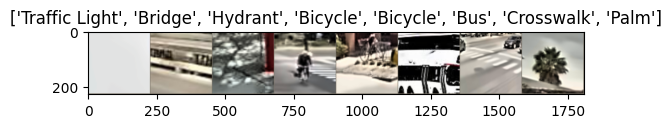

In [ ]:
# Get a batch of training data
inputs, labels = next(iter(dataloaders['train']))
print("inputs.shape:", inputs.shape)
print("labels.shape:", labels.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title=[class_names[x] for x in labels[:8]])

inputs.shape: torch.Size([32, 3, 224, 224])
labels.shape: torch.Size([32])


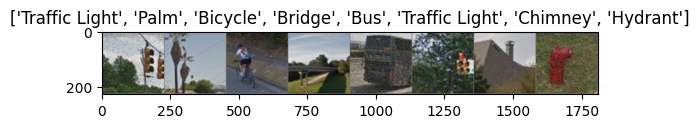

In [ ]:
# Get a batch of validation data
inputs, labels = next(iter(dataloaders['val']))
print("inputs.shape:", inputs.shape)
print("labels.shape:", labels.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:8])

imshow(out, title=[class_names[x] for x in labels[:8]])

## Build model

### EfficientNet from scratch

In [ ]:
class Block(nn.Module):

    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

In [ ]:
from torchvision.models import efficientnet_b0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
model = model.to(device)

### Resnet from model zoo

In [ ]:
# 2. Feature Extracting 설정 (기존 파라미터 freeze)
feature_extract = False

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(model, feature_extract)

# classifier 파라미터만 학습 대상으로 설정
for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)

# 3. 파라미터 설정
params_to_update = [param for param in model.parameters() if param.requires_grad]
print("Params to learn:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print("\t", name)


Params to learn:
	 features.0.0.weight
	 features.0.1.weight
	 features.0.1.bias
	 features.1.0.block.0.0.weight
	 features.1.0.block.0.1.weight
	 features.1.0.block.0.1.bias
	 features.1.0.block.1.fc1.weight
	 features.1.0.block.1.fc1.bias
	 features.1.0.block.1.fc2.weight
	 features.1.0.block.1.fc2.bias
	 features.1.0.block.2.0.weight
	 features.1.0.block.2.1.weight
	 features.1.0.block.2.1.bias
	 features.2.0.block.0.0.weight
	 features.2.0.block.0.1.weight
	 features.2.0.block.0.1.bias
	 features.2.0.block.1.0.weight
	 features.2.0.block.1.1.weight
	 features.2.0.block.1.1.bias
	 features.2.0.block.2.fc1.weight
	 features.2.0.block.2.fc1.bias
	 features.2.0.block.2.fc2.weight
	 features.2.0.block.2.fc2.bias
	 features.2.0.block.3.0.weight
	 features.2.0.block.3.1.weight
	 features.2.0.block.3.1.bias
	 features.2.1.block.0.0.weight
	 features.2.1.block.0.1.weight
	 features.2.1.block.0.1.bias
	 features.2.1.block.1.0.weight
	 features.2.1.block.1.1.weight
	 features.2.1.block.1.1.bi

## Train model

In [ ]:
import time
import copy
import torch
from tqdm import tqdm  # 🔹 진행률 표시용

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\n📘 Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0

            # 🔹 tqdm으로 progress bar 생성
            data_iter = tqdm(dataloaders[phase], desc=f"[{phase.upper()}]", leave=False)

            for inputs, labels in data_iter:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # 🔹 tqdm 상단에 표시할 항목 업데이트
                data_iter.set_postfix({
                    'loss': f"{loss.item():.4f}"
                })

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, "efficient_model.pth")

            if phase == 'val':
                val_acc_history.append(epoch_acc)

    time_elapsed = time.time() - since
    print(f"\n✅ Training complete in {int(time_elapsed // 60)}m {int(time_elapsed % 60)}s")
    print(f"🥇 Best val Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, val_acc_history


In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# 옵티마이저 설정 (둘 중 하나 선택)
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(params_to_update, lr=0.0001)

model, hist = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=10)



📘 Epoch 1/10
------------------------------


Train Loss: 1.1307 Acc: 0.6675


Val Loss: 0.3512 Acc: 0.9025

📘 Epoch 2/10
------------------------------


Train Loss: 0.5591 Acc: 0.8219


Val Loss: 0.2614 Acc: 0.9067

📘 Epoch 3/10
------------------------------


Train Loss: 0.4721 Acc: 0.8479


Val Loss: 0.2178 Acc: 0.9287

📘 Epoch 4/10
------------------------------


Train Loss: 0.4432 Acc: 0.8540


Val Loss: 0.2012 Acc: 0.9371

📘 Epoch 5/10
------------------------------


Train Loss: 0.3996 Acc: 0.8660


Val Loss: 0.2007 Acc: 0.9371

📘 Epoch 6/10
------------------------------


Train Loss: 0.3705 Acc: 0.8778


Val Loss: 0.2014 Acc: 0.9350

📘 Epoch 7/10
------------------------------


Train Loss: 0.3487 Acc: 0.8827


Val Loss: 0.1959 Acc: 0.9423

📘 Epoch 8/10
------------------------------


Train Loss: 0.3432 Acc: 0.8849


Val Loss: 0.1946 Acc: 0.9371

📘 Epoch 9/10
------------------------------


Train Loss: 0.3150 Acc: 0.8974


Val Loss: 0.1914 Acc: 0.9392

📘 Epoch 10/10
------------------------------


Train Loss: 0.3166 Acc: 0.8922


Val Loss: 0.1907 Acc: 0.9413

✅ Training complete in 13m 13s
🥇 Best val Acc: 0.9423


## Save the model & features

In [4]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 69.8 MB/s eta 0:00:00


In [ ]:
def extract_features_efficientnet(model, dataloader, device):
    model.eval()
    features_list = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            x = model.features(inputs)
            x = model.avgpool(x)
            x = torch.flatten(x, 1)

            features_list.append(x.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    features = np.vstack(features_list)
    labels = np.concatenate(labels_list)
    return features, labels


In [ ]:
model = model.to(device)  # 반드시 있어야 함

features, labels = extract_features_efficientnet(model, dataloaders['train'], device)

np.save("features.npy", features.astype(np.float32))
np.save("labels.npy", labels)



In [5]:
import faiss
import numpy as np

# 🔹 features 불러오기
features = np.load("features.npy").astype(np.float32)  # float32 필수

# 🔹 FAISS 인덱스 생성 (L2 거리 기준)
dim = features.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(features)

# 🔹 인덱스 저장
faiss.write_index(index, "faiss_index.bin")

print("✅ faiss_index.bin 저장 완료")



FileNotFoundError: [Errno 2] No such file or directory: 'features.npy'

In [8]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms, models
import faiss
from tqdm import tqdm
import pandas as pd

# 여기만 돌리면됨

# ====== 설정 ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
query_dir = "./query"
input_size = 224

class_names = ['Bicycle', 'Bridge', 'Bus', 'Car',
               'Chimney', 'Crosswalk', 'Hydrant',
               'Motorcycle', 'Palm', 'Traffic Light']

# ====== 모델 불러오기 ======
model = models.efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 10)
model.load_state_dict(torch.load("./hw2v3/efficient_model.pth", map_location=device))
model = model.to(device)
model.eval()

# ====== 전처리 정의 ======
transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ====== 쿼리 이미지 로딩 ======
query_paths = sorted([
    os.path.join(query_dir, fname)
    for fname in os.listdir(query_dir)
    if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
])

# ====== DB 라벨, FAISS 인덱스 로딩 ======
labels = np.load("./hw2v3/labels.npy")
index = faiss.read_index("./hw2v3/faiss_index.bin")

# ====== feature 추출 함수 ======
def extract_feature(model, image_tensor):
    with torch.no_grad():
        x = model.features(image_tensor)
        x = model.avgpool(x)
        x = torch.flatten(x, 1)
        return x.cpu().numpy()

# ====== 예측 수행 ======
top1_preds = []
top10_preds = []
image_names = []

for path in tqdm(query_paths, desc="Evaluating query images"):
    img = Image.open(path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    feat = extract_feature(model, img_tensor)
    D, I = index.search(feat, 11)  # 자기 자신 포함, top-10+1개

    top1 = class_names[labels[I[0][1]]]
    top10 = [class_names[labels[j]] for j in I[0][1:]]

    top1_preds.append(top1)
    top10_preds.append(top10)
    image_names.append(os.path.basename(path))

# ====== CSV 저장 ======
df_top1 = pd.DataFrame({
    "image": image_names,
    "predicted_label": top1_preds
})
df_top1.to_csv("./hw2v3/c2_t1_a3.csv", index=False, encoding='utf-8-sig')

df_top10 = pd.DataFrame(top10_preds, columns=[f"top{i+1}" for i in range(10)])
df_top10.insert(0, "image", image_names)
df_top10.to_csv("./hw2v3/c2_t2_a3.csv", index=False, encoding='utf-8-sig')

print("✅ Top-1 / Top-10 예측 결과 저장 완료")


Evaluating query images: 100%|██████████| 100/100 [00:01<00:00, 55.80it/s]

✅ Top-1 / Top-10 예측 결과 저장 완료
